In [107]:
import tensorflow as  tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np 

In [67]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3 
EPOCHS = 50 

In [68]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../PlaintVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [69]:
class_names = dataset.class_names
class_names

## 0 , 1 , 2 labeled already. 

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [70]:
len(dataset)
## why 68? every element in the dataset is 32 so 68 * 32 = 2176

68

2024-05-14 12:05:40.613716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


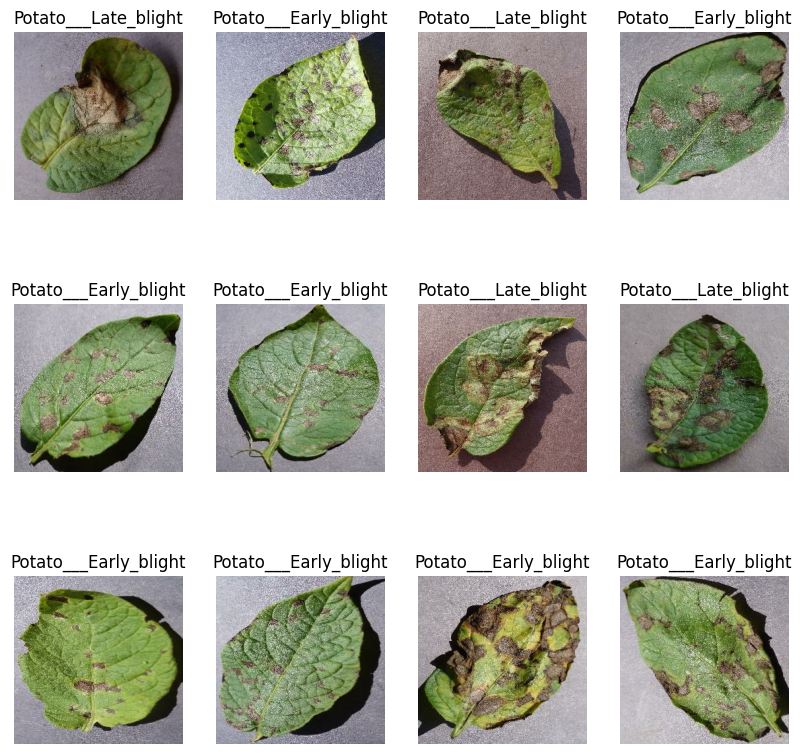

In [71]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]]) # imshow expects 3d array. 
        plt.axis('off')


    #print(image_batch[0].numpy) # tensor to numpy every number is between 0 and 255. 

## 32, 256 image_size and the 3 is RGB 
#

In [72]:
len(dataset)

68

In [73]:
## 80% ==> Training
## 20% ==> 10% validation, 10% test 

In [74]:
train_size = 0.8
len(dataset) * train_size

54.400000000000006

In [75]:
train_ds = dataset.take(54)
len(train_ds)

54

In [76]:
test_ds = dataset.skip(54)
len(test_ds)


14

In [77]:
val_size = 0.1 
len(dataset)*val_size

6.800000000000001

In [78]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [79]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [80]:
# get tensorflow dataset
def get_dataset_partition_tf(ds,train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    assert (train_split + test_split + val_split) == 1 
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) 
    
    return train_ds, val_ds, test_ds 

In [81]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [82]:
len(train_ds)

54

In [83]:
len(val_ds)

6

In [84]:
len(test_ds)

8

In [85]:
## Cache를 쓰면 이미지를 읽는데 있어서 시간을 아낄 수 있음. 

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [86]:
resize_and_rescale = tf.keras.Sequential([
    # Resizing
    # 기존 이미지에 로테이션이나 필터를 넣으면 새로은 샘플을 만드는 거임. 그래서 데이터 augmentation을 하는 거임.  
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE), # Scale the image to 255. 
    layers.Rescaling(1.0/255) # Scale the image to 255. 
])

In [87]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [88]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3 
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3),activation = 'relu', input_shape = input_shape), # kernel size is the size of the filter 
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, kernel_size=(3,3),activation = 'relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation = 'softmax')
    # 2 diff types of pooling. max pooling resizing the image in computational wise. 
    ])
model.build(input_shape=input_shape)

In [89]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_11 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_12 (Sequential)      │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [91]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose =1,
    validation_data = val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 766ms/step - accuracy: 0.4598 - loss: 0.9370 - val_accuracy: 0.5573 - val_loss: 0.9014
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 875ms/step - accuracy: 0.5740 - loss: 0.8126 - val_accuracy: 0.7708 - val_loss: 0.5245
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 45s 825ms/step - accuracy: 0.7206 - loss: 0.5912 - val_accuracy: 0.8490 - val_loss: 0.3725
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 858ms/step - accuracy: 0.8373 - loss: 0.4005 - val_accuracy: 0.8438 - val_loss: 0.3503
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 752ms/step - accuracy: 0.8596 - loss: 0.3247 - val_accuracy: 0.9479 - val_loss: 0.1723
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 47s 859ms/step - accuracy: 0.8971 - loss: 0.2582 - val_accuracy: 0.8646 - val_loss: 0.2730
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 44s 814ms/step - accuracy: 0.8910 - loss: 0.2602 - val_accuracy: 0.9375 - val_loss: 0.1326
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 768ms/step - accuracy: 0.9039 - loss: 0.2306 - val_accu

In [92]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.9927 - loss: 0.0122


In [93]:
scores

[0.011469710618257523, 0.9921875]

In [94]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [95]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [96]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

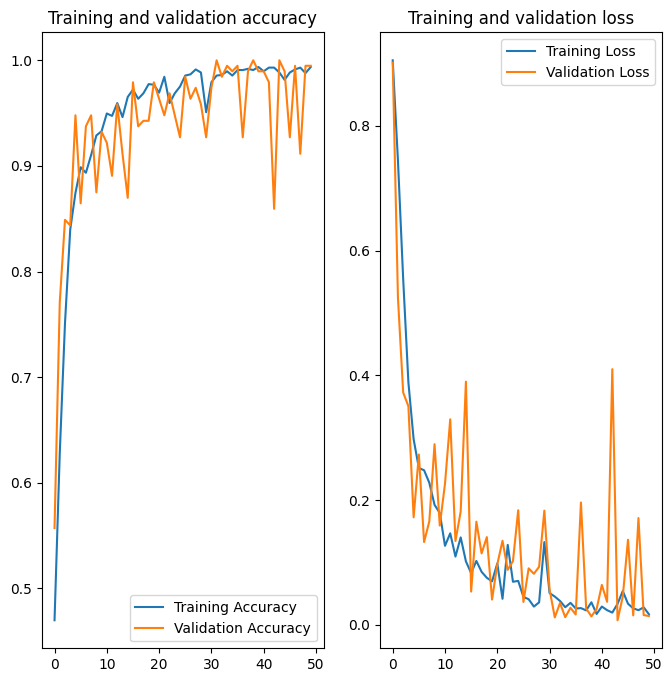

In [99]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label = 'Training Accuracy')
plt.plot(range((EPOCHS)),val_acc,label = 'Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label = 'Training Loss')
plt.plot(range((EPOCHS)),val_loss,label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and validation loss')
plt.show()

first image to predict
first image"s actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
predicted label :  Potato___Late_blight


2024-05-14 13:05:26.927404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


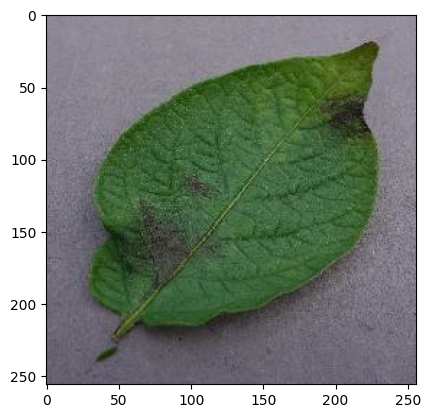

In [110]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    print('first image to predict')
    plt.imshow(first_image)
    print('first image"s actual label:', class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label : ",class_names[np.argmax(batch_prediction[0])])

In [112]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


2024-05-14 13:11:07.825675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


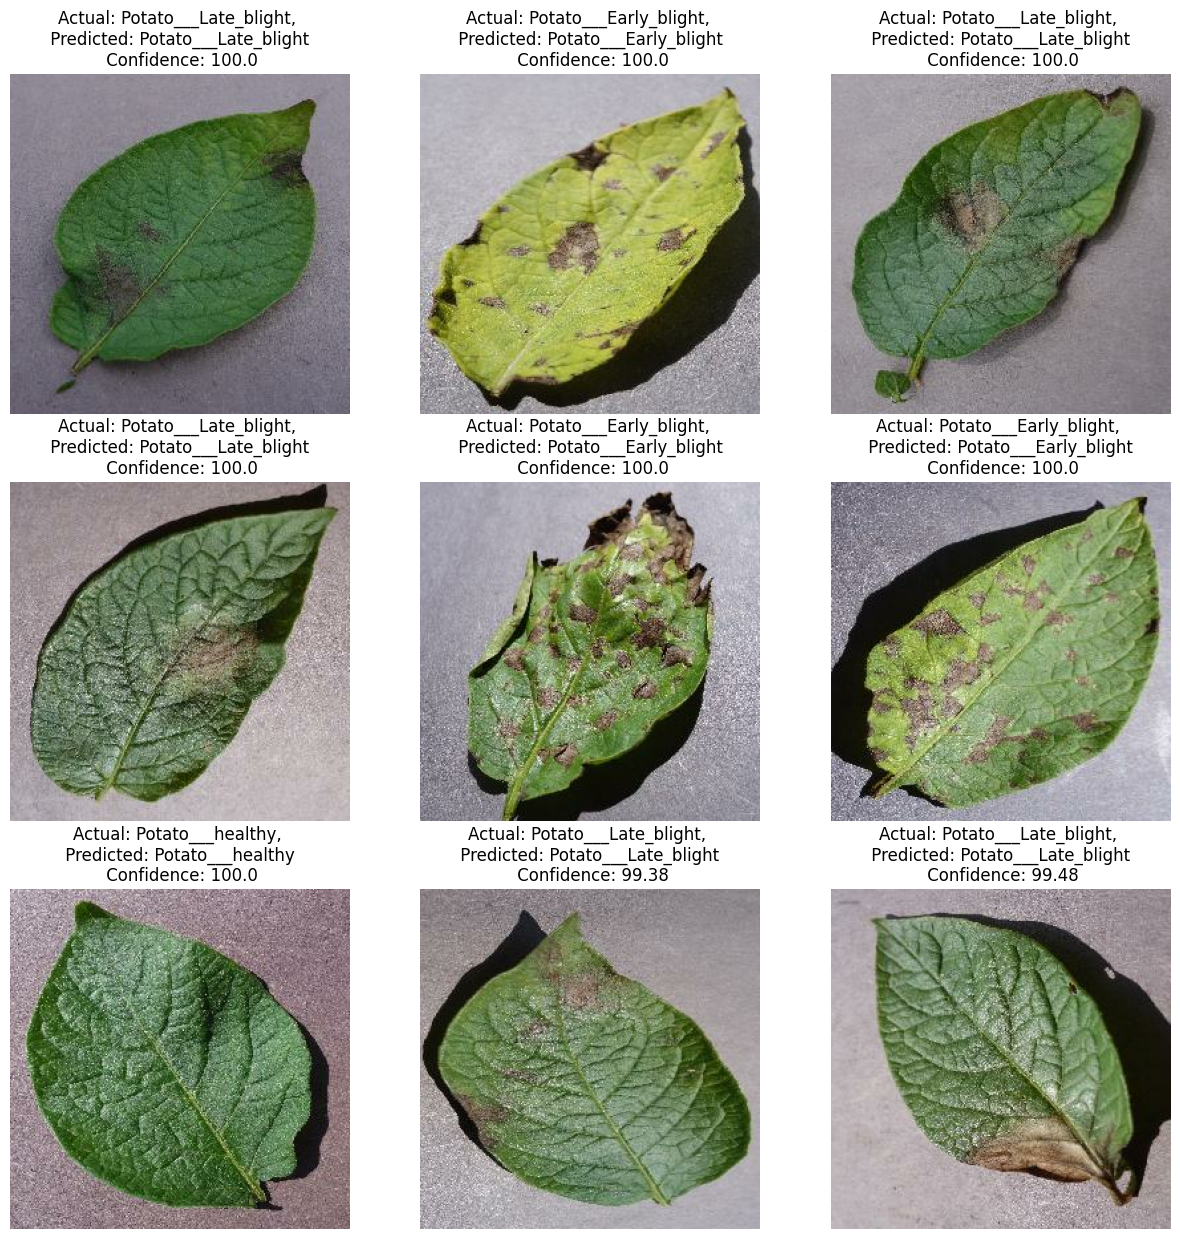

In [117]:
plt.figure(figsize = (15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i +1 )
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}")
        plt.axis("off")

In [133]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=../models/1.

In [134]:
model.save("../potatoes.h5")

TypeError: cannot pickle 'module' object